In [35]:
import json
import random
import pandas as pd
import glob
import os
import sys
import matplotlib.pyplot as plt
import torch
sys.path.append( "..")
sys.path.append("../..")
from utils.util import can_open_images, open_json
from utils.util import is_target_category
from utils.cluster import calc_versatility
from utils.util import calculate_euclid_sum

In [36]:
filepaths = glob.glob('C:/Users/yuuta/Documents/fashion/data/test/**/*.json')

In [49]:
N = 400
# id_to_vector = open_json('C:/Users/yuuta/Documents/fashion/model_learning/versatility/data/id_to_vector_test.json')
id_to_vector = open_json('C:/Users/yuuta/Documents/fashion/experiments/data/id_to_vector_versatility.json')
centroids =  torch.load(f'C:/Users/yuuta/Documents/fashion/model_learning/versatility/cluster/center_tensors_{N}.pt').numpy()

In [39]:
from utils.util import filter_basic_items, get_category

items = {"tops": [], "bottoms": [], "shoes": []}
for fp in filepaths:
    json_dict = open_json(fp)
    if json_dict == None:
        continue
    for item in list(filter(is_target_category, json_dict["items"])):
        category = get_category(item)
        if category == None:
            continue
        items[category].append(str(item['itemId']))

In [40]:
import importlib
import utils
importlib.reload(utils.cluster)
from utils.cluster import calc_versatility

In [50]:
score = []
for NEAREST_ITEM_LENGTH in range(0, N, 10):
    proposal_scores = []
    euclid_scores = []

    for i in range(1000):
        cw = {
            'tops':random.sample(items["tops"], 4),
            'bottoms':random.sample(items["bottoms"], 4),
            'shoes':random.sample(items["shoes"], 4),
        }

        proposal_score = 0
        euclid_score = 0
        for kind in ['tops', 'bottoms', 'shoes']:
            vectors = [torch.tensor(id_to_vector[itemId]) for itemId in cw[kind]]
            s = calc_versatility(centroids, vectors, NEAREST_ITEM_LENGTH)
            proposal_score += len(s)
            euclid_score += calculate_euclid_sum(vectors)
        proposal_scores.append(proposal_score)
        euclid_scores.append(euclid_score)
    df = pd.DataFrame({'proposal': proposal_scores, 'euclid':euclid_scores})

    correlation_matrix = df.corr()

    score.append(correlation_matrix['proposal']['euclid'])


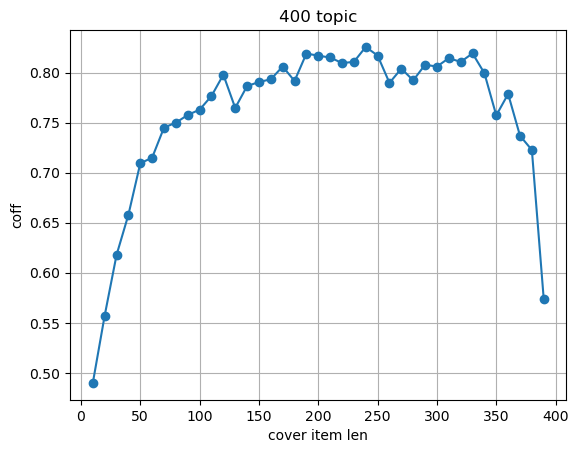

In [51]:
import matplotlib.pyplot as plt

def plot_line_graph(x, y, path):
    plt.figure(1)
    plt.plot(x, y, marker='o', linestyle='-')
    plt.xlabel('cover item len')
    plt.ylabel('coff')
    plt.title(f'{N} topic')
    plt.grid(True)
    plt.savefig(path)

# 折れ線グラフを描画
plot_line_graph(range(0, N, 10), score, f'C:/Users/yuuta/Documents/fashion/experiments/versatility/result/coef_{N}.png')